In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import logomaker as lm
from tqdm import tqdm
from collections import defaultdict
import pickle as pkl
import os
import sys

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
threshold = 1000

v3 = pd.read_csv("2-EGFR-V3-R4.txt", sep='\t', header = 0)
v3 = v3.sort_values("Counts", ascending = False)
v3 = v3.drop(['Name'],axis=1)
v3 = v3[v3.Counts >= threshold]

In [3]:
v3

,Counts,Sequences
0,414972,ACGDRQQACEARGNQCG
1,239543,ACISSEPSCQLKLRDCG
2,179252,ACFWCQYVCALQHVLCG
3,166145,ACQGSQVRCVGGVSGCG
4,132930,ACQYRPLVCYVGVDRCG
...,...,...
1994,1001,ACSQPAEGCTQLVPGCG
1995,1001,ACGCGVSSCLGQRQCCG
1996,1001,ACPTKTRPCAGQSATCG
1997,1001,ACAHRLKQCTEVMQGCG


In [4]:
def check_abnormal_aa(peptide_seq):
    len_seq = len(peptide_seq)
    cnt = 0
    standard_aa = ['G','A','P','V','L','I','M','F','Y','W','S','T','C','N','Q','K','H','R','D','E']
    f=1
    for i in peptide_seq:
        if i not in standard_aa :
            f=0
    return f

In [5]:
v3["all_standard"] = v3.Sequences.apply(check_abnormal_aa)
v3 = v3[v3.all_standard==1]

v3.shape[0]

1997

In [6]:
v3["log_counts"]=np.log10(v3.Counts)
v3 = v3.drop(['all_standard'],axis=1)

/var/folders/7c/lyn20vqd2p76c6_5_dljysx40000gn/T/ipykernel_76275/3095320607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v3["log_counts"]=np.log10(v3.Counts)


In [7]:
v3

,Counts,Sequences,log_counts
0,414972,ACGDRQQACEARGNQCG,5.618019
1,239543,ACISSEPSCQLKLRDCG,5.379383
2,179252,ACFWCQYVCALQHVLCG,5.253464
3,166145,ACQGSQVRCVGGVSGCG,5.220487
4,132930,ACQYRPLVCYVGVDRCG,5.123623
...,...,...,...
1994,1001,ACSQPAEGCTQLVPGCG,3.000434
1995,1001,ACGCGVSSCLGQRQCCG,3.000434
1996,1001,ACPTKTRPCAGQSATCG,3.000434
1997,1001,ACAHRLKQCTEVMQGCG,3.000434


In [8]:
v3_esm = np.load('EGFRv3R4_esm2_t33_650M_UR50D.npy')

In [9]:
DIMRED = TSNE
s = DIMRED(n_components=2, random_state=3).fit_transform(v3_esm)

/Users/minghanwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/minghanwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

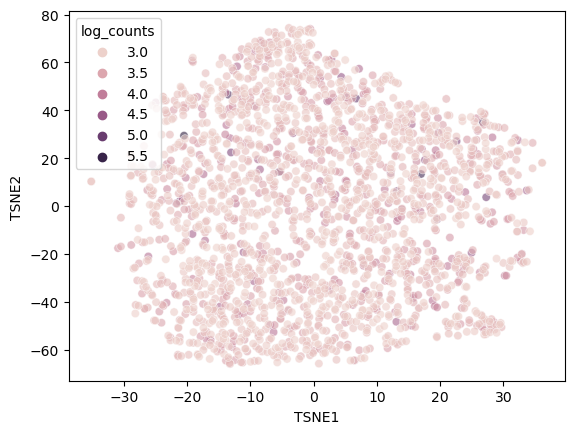

In [10]:
v3["TSNE1"]=s[:,0]
v3["TSNE2"]=s[:,1]
sns.scatterplot(x="TSNE1", y="TSNE2", hue="log_counts",data=v3,alpha=0.6)

In [11]:
kmeans = KMeans(init="random",n_clusters=10,max_iter=300,random_state=42)

In [12]:
kmeans.fit(v3_esm)

KMeans(init='random', n_clusters=10, random_state=42)

In [13]:
v3["cluster"] = kmeans.labels_

In [14]:
v3["cluster"] = v3.cluster.astype(str)

In [15]:
v3

,Counts,Sequences,log_counts,TSNE1,TSNE2,cluster
0,414972,ACGDRQQACEARGNQCG,5.618019,-20.503363,29.418411,1
1,239543,ACISSEPSCQLKLRDCG,5.379383,16.970741,13.376684,9
2,179252,ACFWCQYVCALQHVLCG,5.253464,26.734337,35.107643,9
3,166145,ACQGSQVRCVGGVSGCG,5.220487,-13.471839,46.519081,2
4,132930,ACQYRPLVCYVGVDRCG,5.123623,-5.448143,14.294659,9
...,...,...,...,...,...,...
1994,1001,ACSQPAEGCTQLVPGCG,3.000434,5.265202,23.237598,2
1995,1001,ACGCGVSSCLGQRQCCG,3.000434,-27.824381,-14.128712,3
1996,1001,ACPTKTRPCAGQSATCG,3.000434,11.366875,52.993961,1
1997,1001,ACAHRLKQCTEVMQGCG,3.000434,15.818087,6.530340,9


In [16]:
stat = v3.groupby("cluster").agg({"Counts": ["size", "median", "mean", "max", "min"]})
stat = stat.sort_values(by = ("Counts", "max"), ascending = False)
stat

Counts                                   
          size  median         mean     max   min
cluster                                          
1          229  1506.0  4947.100437  414972  1001
9          343  1477.0  4473.393586  239543  1001
2          261  1477.0  3421.659004  166145  1001
6          214  1429.0  2999.308411   67864  1002
3          140  1610.0  2908.985714   39990  1001
5          233  1643.0  2863.433476   31824  1000
4          148  1400.0  2322.310811   25926  1002
0          192  1428.0  2261.661458   20685  1003
7          162  1449.0  2050.203704   13894  1004
8           75  1446.0  2371.640000   13104  1006

<AxesSubplot:xlabel='TSNE1', ylabel='TSNE2'>

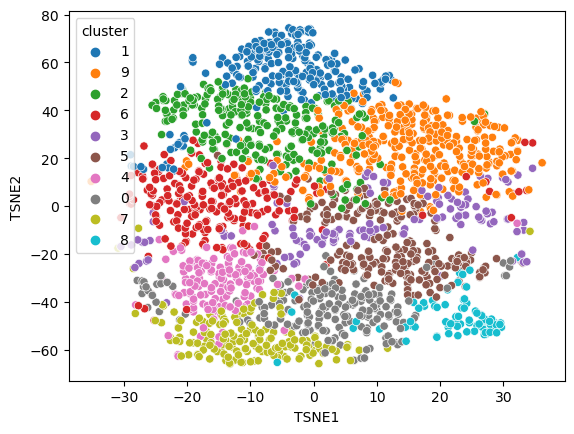

In [17]:
v3["TSNE1"]=s[:,0]
v3["TSNE2"]=s[:,1]
sns.scatterplot(x="TSNE1", y="TSNE2", hue="cluster",data=v3)

In [19]:
def seqlogo_cluster(df,cluster,weighted=False,displot=True):
    c_df=df[df.cluster==cluster]
    # print(f"Cluster: {cluster}, num: {c_df.shape[0]} ")
    if weighted:
        weighted_peptide=[]
        for index,row in c_df.iterrows():
            weighted_peptide.extend([row["Sequences1"]]*row["Counts"])
        matrix=lm.alignment_to_matrix(weighted_peptide,to_type='information')
    else:
        matrix=lm.alignment_to_matrix(c_df.Sequences1,to_type='information')
        
        
    info_logo=lm.Logo(matrix,color_scheme="chemistry")
    info_logo.ax.set_ylabel('information (bits)')
    plt.title(f'Cluster: {cluster}, Size: {c_df.shape[0]},Median counts: {np.median(c_df.Counts)}, Mean counts: {np.mean(c_df.Counts)}, Max count: {np.max(c_df.Counts)}, Min count:{np.min(c_df.Counts)}')
  
    if displot:
        sns.displot(c_df.log_counts)

In [20]:
v3["Sequences1"]=v3.Sequences.apply(lambda x: x[2:8]+x[9:15])
v3

,Counts,Sequences,log_counts,TSNE1,TSNE2,cluster,Sequences1
0,414972,ACGDRQQACEARGNQCG,5.618019,-20.503363,29.418411,1,GDRQQAEARGNQ
1,239543,ACISSEPSCQLKLRDCG,5.379383,16.970741,13.376684,9,ISSEPSQLKLRD
2,179252,ACFWCQYVCALQHVLCG,5.253464,26.734337,35.107643,9,FWCQYVALQHVL
3,166145,ACQGSQVRCVGGVSGCG,5.220487,-13.471839,46.519081,2,QGSQVRVGGVSG
4,132930,ACQYRPLVCYVGVDRCG,5.123623,-5.448143,14.294659,9,QYRPLVYVGVDR
...,...,...,...,...,...,...,...
1994,1001,ACSQPAEGCTQLVPGCG,3.000434,5.265202,23.237598,2,SQPAEGTQLVPG
1995,1001,ACGCGVSSCLGQRQCCG,3.000434,-27.824381,-14.128712,3,GCGVSSLGQRQC
1996,1001,ACPTKTRPCAGQSATCG,3.000434,11.366875,52.993961,1,PTKTRPAGQSAT
1997,1001,ACAHRLKQCTEVMQGCG,3.000434,15.818087,6.530340,9,AHRLKQTEVMQG


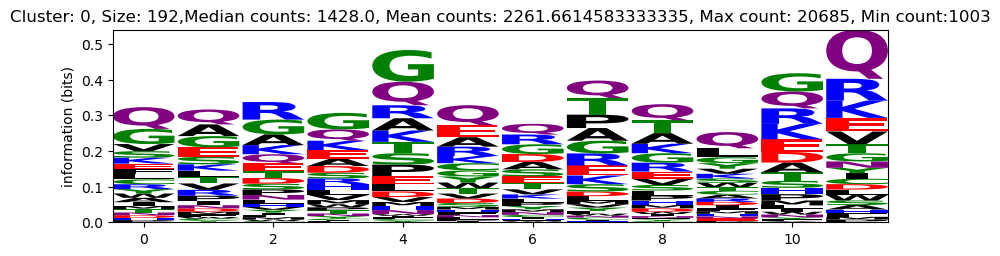

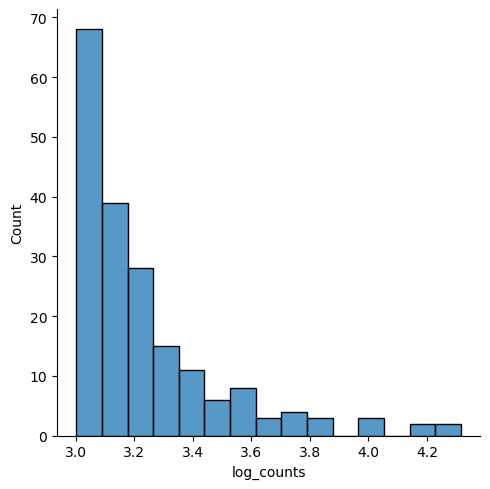

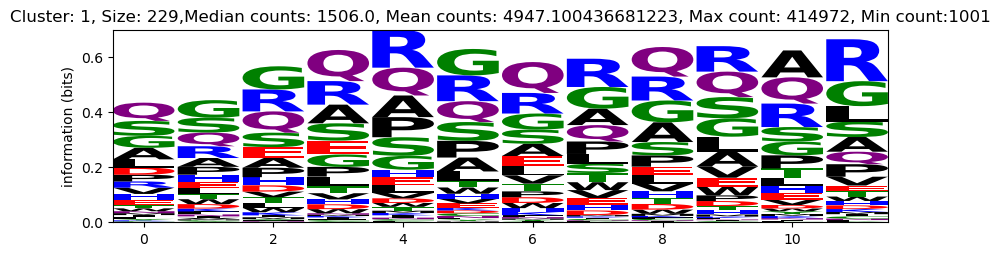

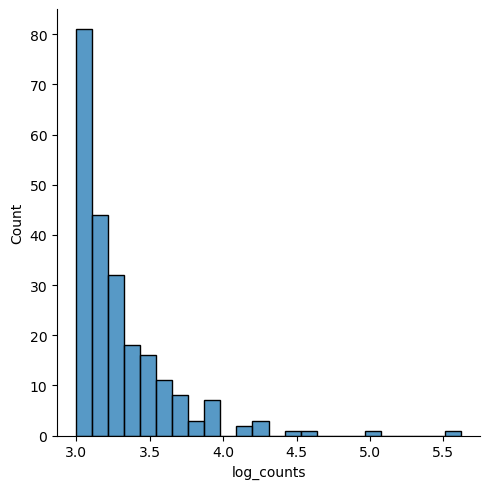

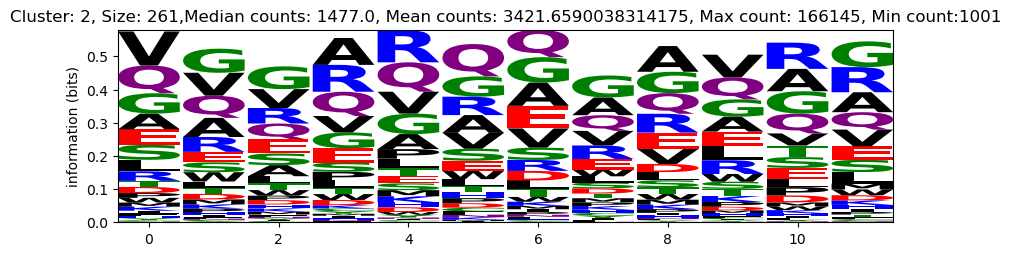

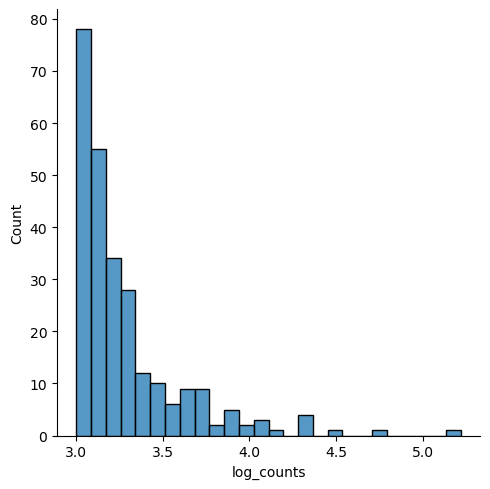

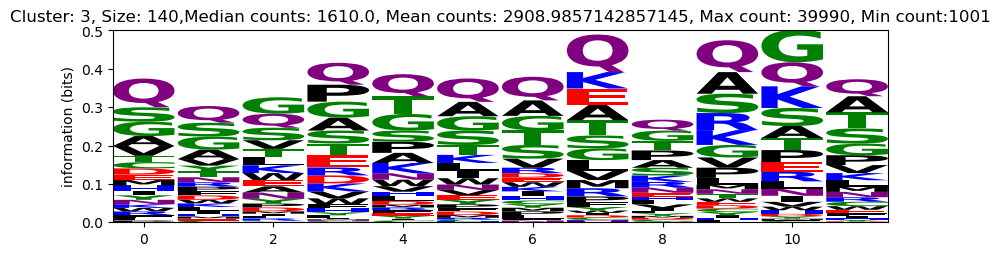

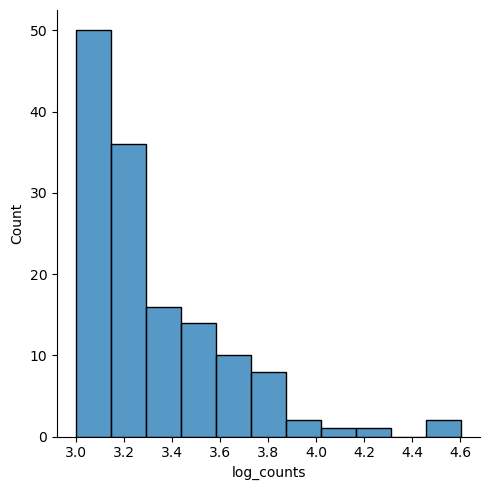

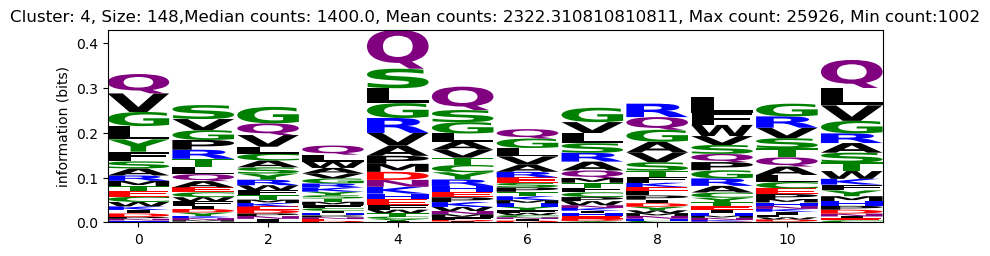

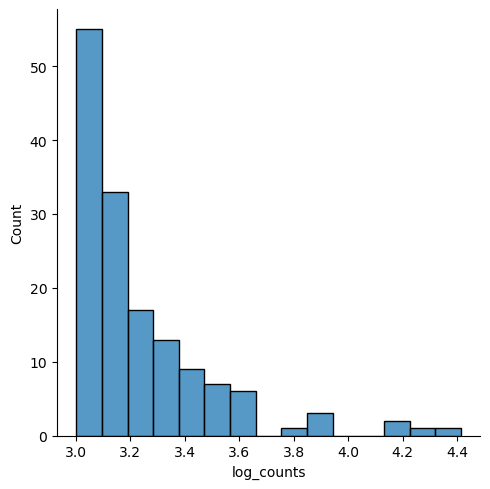

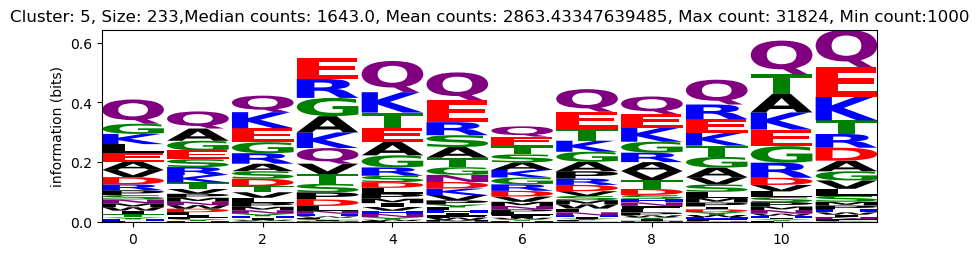

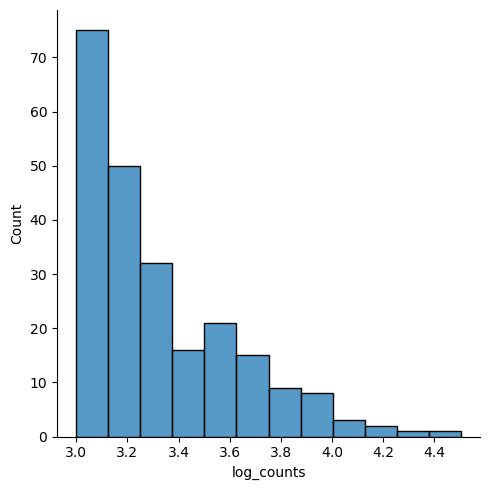

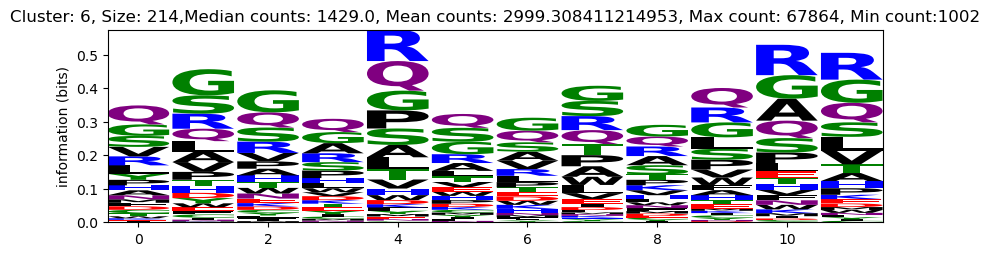

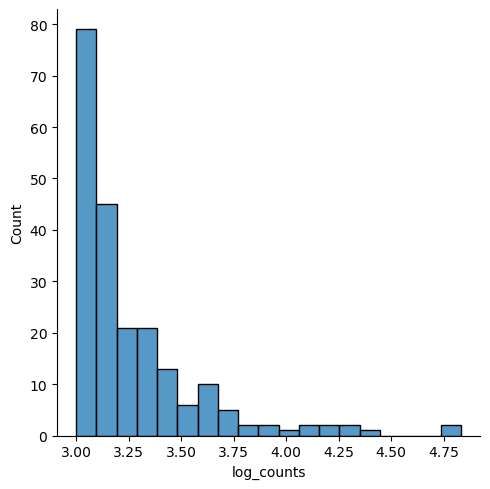

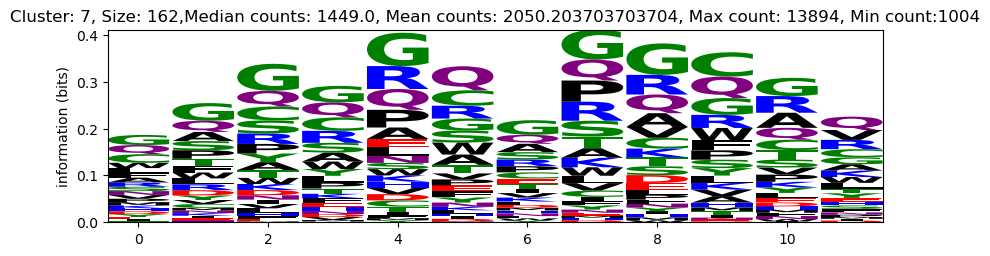

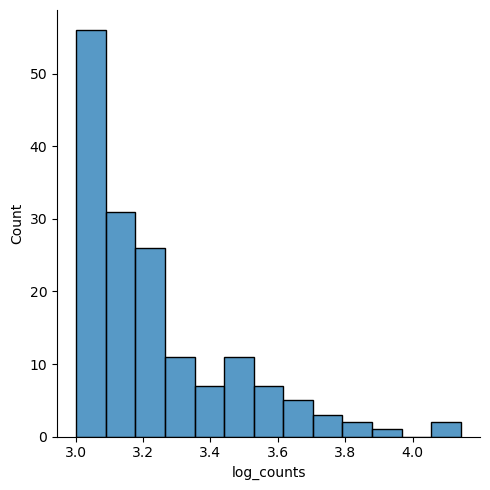

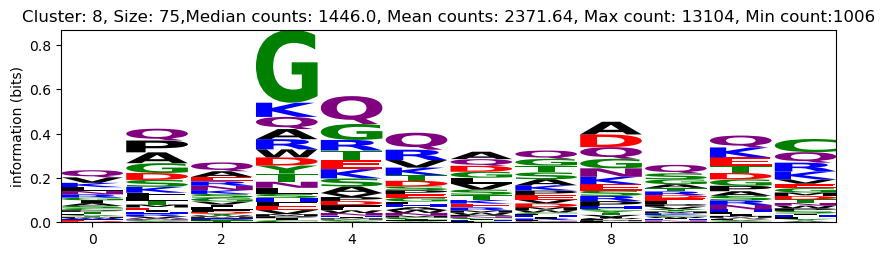

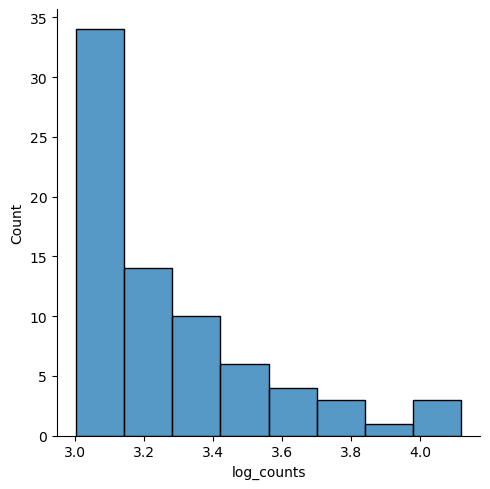

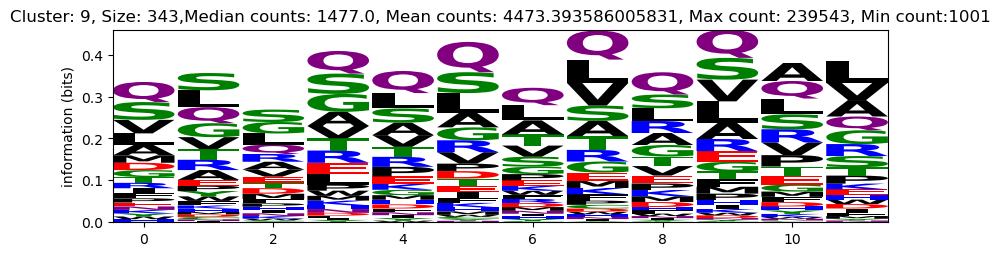

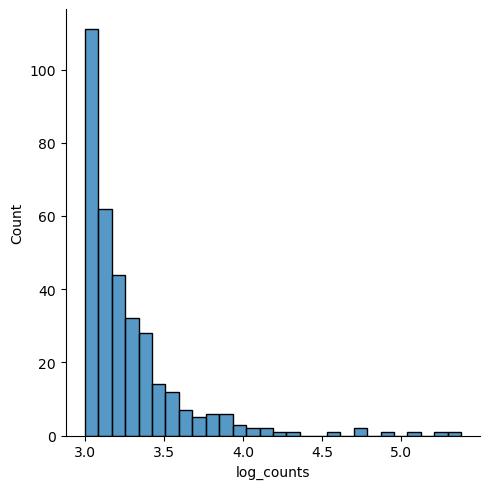

In [21]:
for i in range(10):
    seqlogo_cluster(v3,str(i))

In [39]:
stat.to_csv("EGFRv3R4_esm_cluster_statistics.csv")
v3.loc[:, ["Sequences", "Counts", "cluster"]].to_csv('EGFRv3R4_esm_cluster.csv')